In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [3]:
import json

In [4]:
import ast

import ast_scope
import pandas as pd
import requests
import tqdm.auto as tqdm
import neurosym as ns
import matplotlib.pyplot as plt

from imperative_stitch.compress.julia_stitch import run_julia_stitch
from imperative_stitch.compress.abstraction import Abstraction
from imperative_stitch.compress.manipulate_abstraction import (
    abstraction_calls_to_bodies,
    abstraction_calls_to_bodies_recursively,
    abstraction_calls_to_stubs,
    collect_abstraction_calls,
    replace_abstraction_calls,
)
from imperative_stitch.data.github_repository_downloader import (
    single_repo_random_subset_of_size,
    one_each,
    multiple_repos_random_subset_of_size,
)

In [5]:
from imperative_stitch.utils.remove_docstrings import remove_docstrings
from imperative_stitch.experiments.compression_hyperparameter_search.datasets import (
    datasets,
    sizes,
    datasets_for_size,
)
from imperative_stitch.experiments.compression_hyperparameter_search.hyperparameters import (
    sample_hyperparameters,
)
from imperative_stitch.experiments.compression_hyperparameter_search.run_stitch import (
    run_stitch_with_hyperparameters,
)
from imperative_stitch.experiments.compression_hyperparameter_search.run_experiment import (
    run_experiment_up_to_seed,
)
from imperative_stitch.experiments.compression_hyperparameter_search.analysis import *

In [6]:
d = datasets()

In [7]:
rs = run_experiment_up_to_seed(10, sample_hyperparameters, skip_missing=True)

  0%|          | 0/150 [00:00<?, ?it/s]

Skipping ('ml_repo', 1000000) with seed 1
Skipping ('ml_repo', 1000000) with seed 0
Skipping ('ml_repo', 1000000) with seed 5
Skipping ('ml_repo', 1000000) with seed 8
Skipping ('ml_repo', 1000000) with seed 7
Skipping ('ml_repo', 1000000) with seed 9


In [8]:
subjective_scores = [None] * len(rs)

In [9]:
print_out_abstractions(0, rs[0])
subjective_scores[0] = "D", "not much created, some of what exists is somewhat dubious"

********************************************************************************
0 ('ml_repo', 300000)
           ****************************************
           fn_1 :: 14 [7, 7]
           def %4(%1, %3=None):
               if %1.built:
                   return
               %1.built = True
               ?0
               if getattr(%1, #2, None) is not None:
                   with %2.name_scope(#1.name):
                       #1.build(#0)
               ?1
           ****************************************
           fn_2 :: 23 [10, 13]
           if getattr(%2, #2, None) is not None:
               with %1.name_scope(#1.name):
                   #1.build(#0)
********************************************************************************
0 ('system_repo', 1000000)
           ****************************************
           fn_1 :: 11 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
           import json
           import logging
           ?0
           %1 = logging.getLogger(__nam

In [10]:
print_out_abstractions(1, rs[1])
subjective_scores[1] = "F", "far far far too small abstractions. Gets in loops"

********************************************************************************
1 ('system_repo', 10000)
           ****************************************
           fn_1 :: 48 [29, 3, 9, 7]
           %1 = #0
           ****************************************
           fn_2 :: 0 []
           fn_1(__code__('#0'), __ref__(%1))
           ****************************************
           fn_3 :: 0 []
           fn_2(__code__('#0'), __ref__(%1))
           ****************************************
           fn_4 :: 0 []
           fn_3(__code__('#0'), __ref__(%1))
           ****************************************
           fn_5 :: 0 []
           fn_4(__code__('#0'), __ref__(%1))
           ****************************************
           fn_6 :: 0 []
           fn_5(__code__('#0'), __ref__(%1))
           ****************************************
           fn_7 :: 0 []
           fn_6(__code__('#0'), __ref__(%1))
           ****************************************
         

In [11]:
print_out_abstractions(2, rs[2])
subjective_scores[2] = (
    "C",
    "some good abstractions, but also many far too small abstractions",
)

********************************************************************************
2 ('ml_repo', 100000)
           ****************************************
           fn_1 :: 4 [1, 1, 1, 1]
           if __name__ == '__main__':
               ?0
           ****************************************
           fn_2 :: 4 [1, 3]
           %1.info(f'  Num examples = {len(#0)}')
           ****************************************
           fn_3 :: 4 [2, 2]
           %1.utils.logging.set_verbosity_error()
********************************************************************************
2 ('system_repo', 100000)
           ****************************************
           fn_1 :: 5 [1, 1, 1, 1, 1]
           import numpy as np
           ****************************************
           fn_2 :: 7 [1, 1, 1, 1, 1, 1, 1]
           import ray
           ****************************************
           fn_3 :: 4 [1, 1, 1, 1]
           import logging
           ?0
           %1 = logging.ge

In [12]:
print_out_abstractions(3, rs[3])
subjective_scores[3] = (
    "B",
    "some good and very large abstractions, but also many import-only or other small abstractions",
)

********************************************************************************
3 ('system_repo', 30000)
           ****************************************
           fn_1 :: 3 [1, 1, 1]
           import numpy as np
********************************************************************************
3 ('across_repos', 30000)
           ****************************************
           fn_1 :: 7 [2, 1, 4]
           def %3(%2, %1):
               ?0
           
           def %6(%5, %4):
               ?1
********************************************************************************
3 ('ml_repo', 100000)
           ****************************************
           fn_1 :: 6 [1, 2, 2, 1]
           %3.upload_folder(commit_message=#0, folder_path=%1.output_dir, repo_id=%2, repo_type='model', token=%1.hub_token)
           ****************************************
           fn_2 :: 4 [1, 3]
           %1.info(#0)
           %1.info(f'  Num examples = {len(#1)}')
           %1.info(#2)

In [13]:
print_out_abstractions(4, rs[4])
subjective_scores[4] = "D", "couple middling abstractions, couple bad abstractions"

********************************************************************************
4 ('ml_repo', 300000)
           ****************************************
           fn_1 :: 37 [17, 20]
           if getattr(%2, #2, None) is not None:
               with %1.name_scope(#1.name):
                   #1.build(#0)
           ****************************************
           fn_2 :: 29 [8, 12, 9]
           %1 = %1 if %1 is not None else #0
           ****************************************
           fn_3 :: 34 [5, 3, 1, 1, 1, 1, 4, 3, 10, 3, 2]
           if #1:
               raise ValueError(#0)
********************************************************************************
4 ('system_repo', 300000)
           ****************************************
           fn_1 :: 24 [1, 4, 1, 5, 1, 1, 1, 3, 1, 1, 1, 2, 2]
           if #1:
               raise ValueError(#0)
********************************************************************************
4 ('ml_repo', 1000000)
           ******

In [14]:
print_out_abstractions(5, rs[5])
subjective_scores[5] = "B", "only good abstractions, but no great abstractions"

********************************************************************************
5 ('ml_repo', 300000)
           ****************************************
           fn_1 :: 12 [6, 6]
           def %4(%1, %3=None):
               if %1.built:
                   return
               %1.built = True
               ?0
               if getattr(%1, #2, None) is not None:
                   with %2.name_scope(#1.name):
                       #1.build(#0)
           ****************************************
           fn_2 :: 6 [2, 4]
           %2 = %2 if %2 is not None else %1.config.output_attentions
           %3 = %3 if %3 is not None else %1.config.output_hidden_states
           %4 = %4 if %4 is not None else #0
           ****************************************
           fn_3 :: 3 [1, 2]
           %1 = #0
           %1 = %2 + %1
           ?0
           %2 = %1
           ?1
           %1 = #1(%1)
           %1 = #0
           %1 = %2 + %1
           *****************************

In [15]:
print_out_abstractions(6, rs[6])
subjective_scores[6] = "D", "every abstraction is pretty small and useless"

********************************************************************************
6 ('ml_repo', 100000)
           ****************************************
           fn_1 :: 34 [10, 10, 1, 1, 1, 1, 3, 7]
           import %1
           ****************************************
           fn_2 :: 100 [22, 44, 1, 3, 6, 5, 19]
           #1(#0)
           ****************************************
           fn_3 :: 78 [18, 29, 2, 3, 5, 2, 1, 3, 5, 10]
           %1 = #1(#0)
           ****************************************
           fn_4 :: 46 [10, 13, 4, 5, 4, 2, 4, 4]
           %1[#1] = #0
********************************************************************************
6 ('system_repo', 100000)
           ****************************************
           fn_1 :: 43 [5, 3, 9, 3, 17, 3, 2, 1]
           #0(%1)
           ****************************************
           fn_2 :: 35 [4, 1, 2, 3, 5, 6, 2, 4, 4, 4]
           %1 = #0()
           ****************************************

In [16]:
s = 7
print_out_abstractions(s, rs[s])
subjective_scores[s] = "F", "literally only finds 1 abstraction total"

********************************************************************************
7 ('ml_repo', 300000)
           ****************************************
           fn_1 :: 19 [7, 12]
           if getattr(#2, #1, None) is not None:
               with %1.name_scope(#0.name):
                   #0.build(None)


In [17]:
s = 8
print_out_abstractions(s, rs[s])
subjective_scores[s] = "B", "finds many good abstractions, but not the neural net one"

********************************************************************************
8 ('ml_repo', 100000)
           ****************************************
           fn_1 :: 4 [1, 3]
           %1.info(#0)
           %1.info(f'  Num examples = {len(#1)}')
           %1.info(#2)
           ****************************************
           fn_2 :: 3 [1, 2]
           %3.upload_folder(commit_message=#0, folder_path=%1.output_dir, repo_id=%2, repo_type='model', token=%1.hub_token)
           ****************************************
           fn_3 :: 9 [8, 1]
           %1.add_argument(#1, action='store_true', help=#0)
           ****************************************
           fn_4 :: 3 [2, 1]
           return len(#0 + %2 + %1) * [0]
********************************************************************************
8 ('ml_repo', 300000)
           ****************************************
           fn_1 :: 41 [1, 3, 17, 20]
           if getattr(%2, #2, None) is not None:
            

In [18]:
s = 9
print_out_abstractions(s, rs[s])
subjective_scores[s] = "D", "all abstractions are far too small"

********************************************************************************
9 ('ml_repo', 30000)
           ****************************************
           fn_1 :: 13 [10, 3]
           import %1
           ****************************************
           fn_2 :: 12 [7, 5]
           %1 = #0()
           ****************************************
           fn_3 :: 0 []
           fn_1(__ref__(%1))
           ****************************************
           fn_4 :: 0 []
           fn_3(__ref__(%1))
           ****************************************
           fn_5 :: 0 []
           fn_4(__ref__(%1))
           ****************************************
           fn_6 :: 0 []
           fn_5(__ref__(%1))
           ****************************************
           fn_7 :: 0 []
           fn_6(__ref__(%1))
           ****************************************
           fn_8 :: 0 []
           fn_7(__ref__(%1))
           ****************************************
           

In [19]:
subjective_scores_grade, subjective_scores_desc = zip(*subjective_scores)

In [20]:
results = pd.DataFrame(
    {
        i: {
            **sample_hyperparameters(i),
            **{("wall_time", *k): wall_time(v) for k, v in r.items()},
            **{("compression", *k): s_exp_compression(v) for k, v in r.items()},
            "grade": subjective_scores_grade[i],
            "description": subjective_scores_desc[i],
        }
        for i, r in enumerate(rs)
    }
).T
results_no_infcol = results[
    [
        x
        for x in results
        if not isinstance(x, tuple) or np.isfinite(list(results[x])).all()
    ]
]
mean_by_repo_size = {x[1:]: np.mean(results[x]) for x in results if x[0] == "wall_time"}

In [21]:
scaling_table = pd.DataFrame(
    {
        size: {
            k: mean_by_repo_size.get((k, size), np.nan) for k in datasets_for_size(size)
        }
        for size in sizes
    }
).T

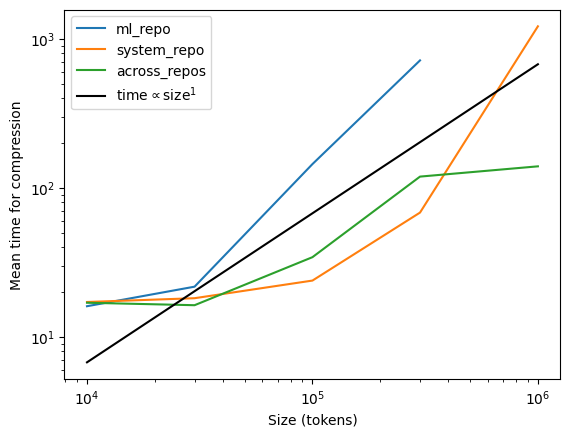

In [22]:
for repo in scaling_table:
    plt.plot(scaling_table.index, scaling_table[repo], label=repo)
mid_idx = scaling_table.shape[0] // 2
for power in (1,):
    plt.plot(
        scaling_table.index,
        (scaling_table.index / scaling_table.index[mid_idx]) ** power
        * scaling_table.iloc[mid_idx].mean(),
        label=rf"$\mathrm{{time}} \propto \mathrm{{size}}^{power}$",
        color="black",
    )
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Size (tokens)")
plt.ylabel("Mean time for compression")
plt.legend()
plt.show()

In [23]:
results_summary = results_no_infcol[
    [x for x in results_no_infcol if not isinstance(x, tuple)]
].copy()
results_summary["median_time"] = results_no_infcol[
    [x for x in results_no_infcol if x[0] == "wall_time"]
].T.median()
results_summary["median_compression"] = results_no_infcol[
    [x for x in results_no_infcol if x[0] == "compression"]
].T.median()

In [24]:
results_summary.sort_values("grade")

,max_arity,minimum_number_matches,application_utility_metavar,application_utility_symvar,application_utility_fixed,grade,description,median_time,median_compression
3,3,3,-1.832263,-0.064672,-2.527109,B,"some good and very large abstractions, but als...",32.879358,1.003587
5,4,3,-1.779798,-0.226072,-11.653953,B,"only good abstractions, but no great abstractions",23.992421,1.0
8,4,3,-0.2737,-0.237019,-5.085989,B,"finds many good abstractions, but not the neur...",22.339581,1.0
2,1,4,-2.681518,-1.475672,-1.989304,C,"some good abstractions, but also many far too ...",23.347364,1.000698
0,5,11,-1.859604,-0.975773,-5.636892,D,"not much created, some of what exists is somew...",19.866076,1.0
4,3,24,-0.189582,-0.967657,-2.817416,D,"couple middling abstractions, couple bad abstr...",17.727285,1.0
6,3,30,-0.234971,-0.033206,-1.386627,D,every abstraction is pretty small and useless,30.123131,1.007984
9,5,9,-0.684729,-0.071837,-0.459842,D,all abstractions are far too small,63.883092,1.010276
1,4,15,-0.000114,-0.180006,-0.476129,F,far far far too small abstractions. Gets in loops,49.19092,1.004843
7,5,17,-0.576982,-0.642709,-11.448709,F,literally only finds 1 abstraction total,20.500764,1.0


In [25]:
def plot_against(x, y):
    plt.scatter(results_summary[x], results_summary[y], marker=".")
    for i in range(results_summary.shape[0]):
        plt.text(results_summary[x][i], results_summary[y][i], i)
    plt.xlabel(x)
    plt.ylabel(y)

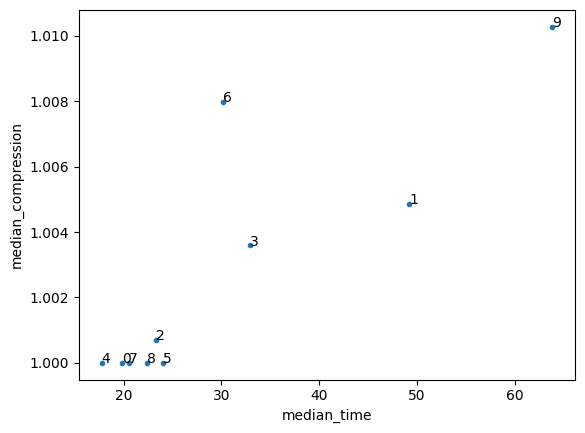

In [26]:
plot_against("median_time", "median_compression")

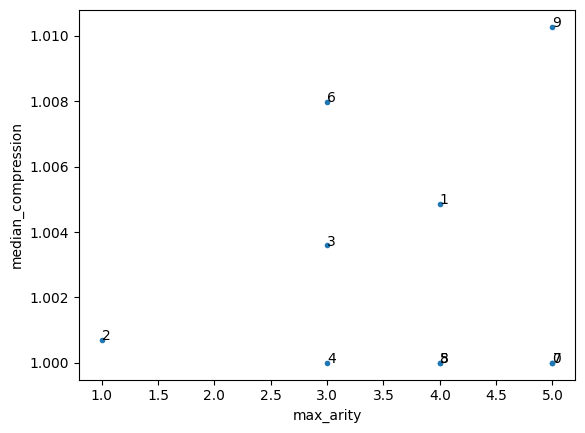

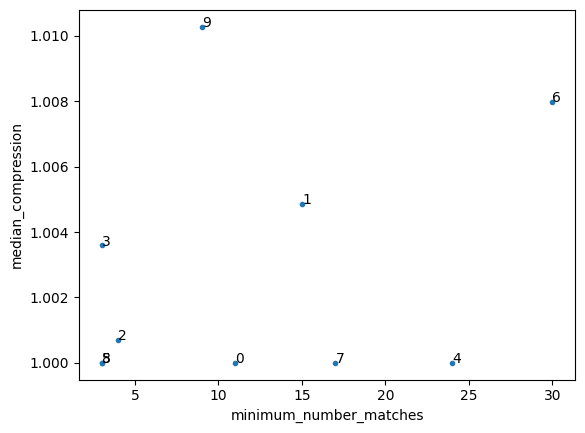

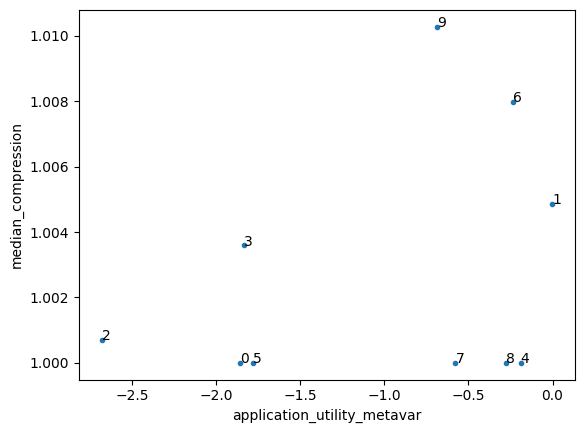

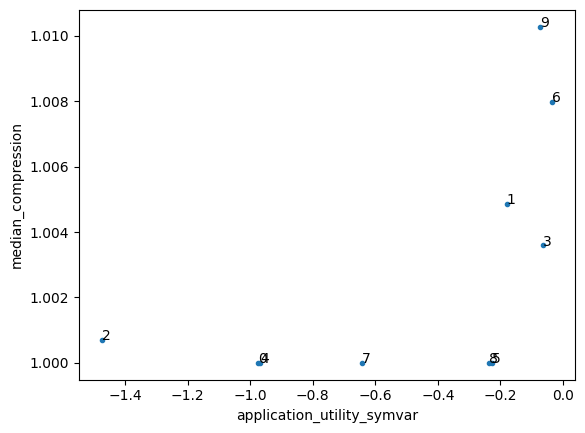

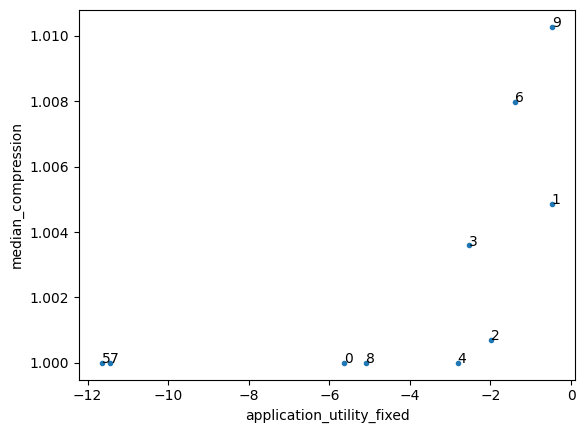

/scratch/kavig/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/text.py:753: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posx = float(self.convert_xunits(self._x))
/scratch/kavig/anaconda3/envs/py311/lib/python3.11/site-packages/matplotlib/text.py:894: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = float(self.convert_xunits(self._x))


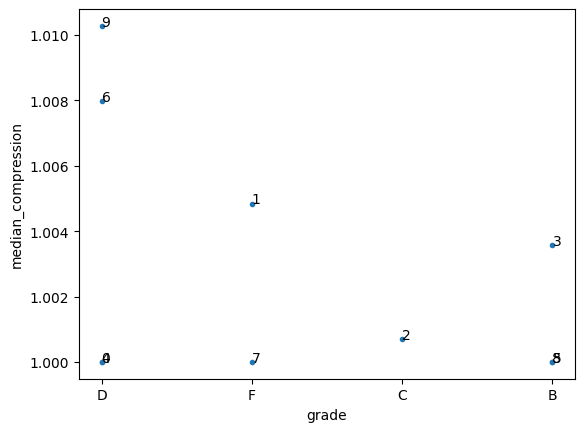

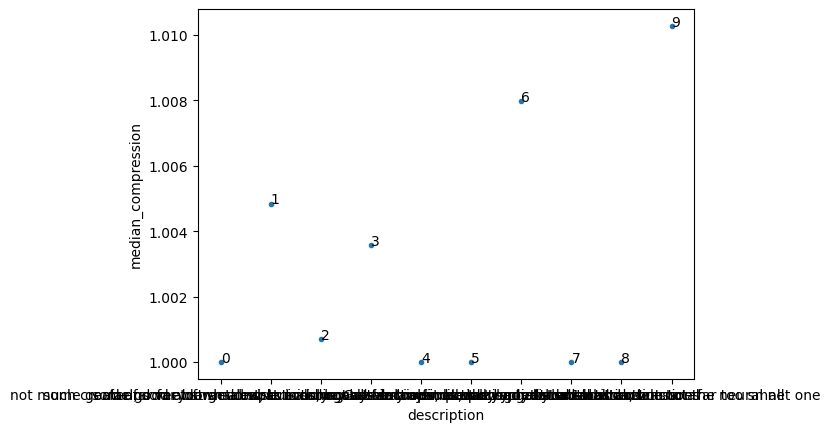

In [27]:
for k in results_summary:
    if k.startswith("median"):
        continue
    plot_against(k, "median_compression")
    plt.show()